In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [3]:
# set up device
dev = qml.device("default.qubit")

In [4]:
def state_preparation(x):
    qml.RY(x, wires=0)
    qml.Hadamard(wires=1)

In [5]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT([0,1])

In [6]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [7]:
def sine_func(weights, bias, x):
    return circuit(weights, x) + bias

In [8]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [9]:
def cost(weights, bias, X, Y):
    predictions = [sine_func(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

#### Create Datasets

In [10]:
# preparation of input values in the range of [0, 2*pi)
values = np.linspace(0, 2*np.pi, 100)

In [11]:
# random distribution of data into 80:20 ratio for train:test

sets = {'train': {'x': [], 'y': []}, 'test': {'x': [], 'y': []}}

for i in values:
    if np.random.rand() < 0.8:
        sets['train']['x'].append(i)
        sets['train']['y'].append(np.sin(i))
    else:
        sets['test']['x'].append(i)
        sets['test']['y'].append(np.sin(i))        

#### Optimization

In [20]:
np.random.seed(0)
num_qubits = 2
num_layers = 1
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]]]
Bias:  0.0


In [25]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 16

In [27]:
weights = weights_init
bias = bias_init
for it in range(20):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(sets['train']['x']), (batch_size,))
    batch_index = np.array(batch_index, dtype=int)
    X_batch = np.array(sets['train']['x'])[batch_index]
    Y_batch = np.array(sets['train']['y'])[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute cost
    current_cost = cost(weights, bias, sets['train']['x'], sets['train']['y'])

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f}")

Iter:    1 | Cost: 1.0580099
Iter:    2 | Cost: 0.0013997
Iter:    3 | Cost: 0.0402123
Iter:    4 | Cost: 0.0040234
Iter:    5 | Cost: 0.0035602
Iter:    6 | Cost: 0.0012906
Iter:    7 | Cost: 0.0000329
Iter:    8 | Cost: 0.0001330
Iter:    9 | Cost: 0.0001615
Iter:   10 | Cost: 0.0000412
Iter:   11 | Cost: 0.0000034
Iter:   12 | Cost: 0.0000211
Iter:   13 | Cost: 0.0000109
Iter:   14 | Cost: 0.0000011
Iter:   15 | Cost: 0.0000006
Iter:   16 | Cost: 0.0000010
Iter:   17 | Cost: 0.0000007
Iter:   18 | Cost: 0.0000004
Iter:   19 | Cost: 0.0000002
Iter:   20 | Cost: 0.0000003


#### Plots

In [28]:
import matplotlib.pyplot as plt

In [29]:
train_results = {'x': [], 'y': []}
for x in sets['train']['x']:
    train_results['x'].append(x)
    train_results['y'].append(sine_func(weights, bias, x))

test_results = {'x': [], 'y': []}
for x in sets['test']['x']:
    test_results['x'].append(x)
    test_results['y'].append(sine_func(weights, bias, x))

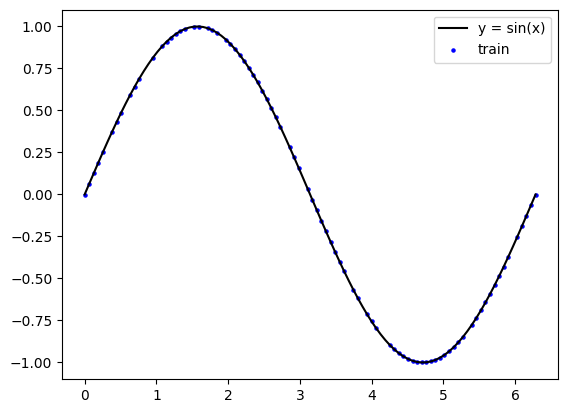

In [30]:
plt.plot(values, np.sin(values), color = 'black', label = 'y = sin(x)')
plt.scatter(train_results['x'], train_results['y'], color = 'blue', label = 'train', s = 5)
plt.legend()
plt.show()

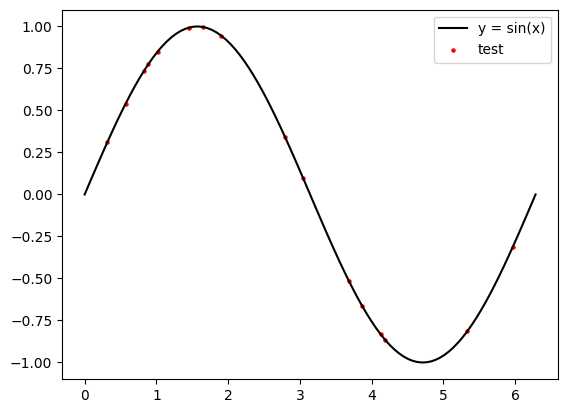

In [31]:
plt.plot(values, np.sin(values), color = 'black', label = 'y = sin(x)')
plt.scatter(test_results['x'], test_results['y'], color = 'red', label = 'test', s = 5)
plt.legend()
plt.show()